In [1]:
# Sistema Avanzado de Embeddings con Fine-tuning para ONGs
# Versión mejorada con capacidades de optimización específica del dominio

# ============================================================================
# INSTALACIÓN DE LIBRERÍAS
# ============================================================================
!pip install sentence-transformers scikit-learn pandas numpy matplotlib seaborn
!pip install transformers torch faiss-cpu umap-learn
!pip install nltk spacy
!python -m spacy download es_core_news_sm

# ============================================================================
# IMPORTACIONES
# ============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation
from sentence_transformers import models, datasets
from torch.utils.data import DataLoader
import torch
import re
import warnings
from datetime import datetime
import json
import pickle
from pathlib import Path
from typing import Dict, List, Optional, Tuple, Any
import logging
from collections import defaultdict
import nltk
from nltk.corpus import stopwords
import spacy

warnings.filterwarnings('ignore')

# Configuración de logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Descargar recursos necesarios
try:
    nltk.download('stopwords', quiet=True)
    # Cargar modelo de spaCy para español
    nlp = spacy.load("es_core_news_sm")
except:
    logger.warning("No se pudo cargar el modelo de spaCy. Algunas funcionalidades estarán limitadas.")
    nlp = None

print("✅ Sistema avanzado de embeddings inicializado")

# ============================================================================
# CONFIGURACIÓN Y CONSTANTES
# ============================================================================

# Diccionario de términos específicos del dominio de ONGs
TERMINOS_DOMINIO_ONG = {
    'educacion': ['educación', 'enseñanza', 'aprendizaje', 'escuela', 'formación', 'capacitación',
                  'taller', 'curso', 'beca', 'alfabetización', 'escolar', 'estudiante'],
    'salud': ['salud', 'médico', 'hospital', 'clínica', 'enfermedad', 'tratamiento', 'terapia',
              'rehabilitación', 'medicina', 'atención médica', 'paciente', 'sanidad'],
    'asistencia_social': ['asistencia', 'ayuda', 'apoyo', 'vulnerabilidad', 'pobreza', 'necesidad',
                          'emergencia', 'crisis', 'refugio', 'alimento', 'comedor', 'hogar'],
    'infancia': ['niño', 'niña', 'infancia', 'infantil', 'menor', 'adolescente', 'juventud',
                 'joven', 'pediatría', 'guardería', 'orfanato'],
    'discapacidad': ['discapacidad', 'capacidades diferentes', 'inclusión', 'accesibilidad',
                     'movilidad reducida', 'visual', 'auditiva', 'cognitiva', 'adaptación'],
    'genero': ['mujer', 'género', 'violencia', 'igualdad', 'empoderamiento', 'feminismo',
               'maternidad', 'embarazo', 'lactancia'],
    'tercera_edad': ['adulto mayor', 'anciano', 'vejez', 'geriátrico', 'jubilado', 'pensionado',
                     'envejecimiento', 'gerontología'],
    'medio_ambiente': ['ambiente', 'ecología', 'sostenible', 'reciclaje', 'verde', 'naturaleza',
                       'conservación', 'biodiversidad', 'clima', 'contaminación'],
    'desarrollo_comunitario': ['comunidad', 'barrio', 'vecinal', 'desarrollo', 'participación',
                               'organización', 'cooperativa', 'microemprendimiento']
}

# Pesos para diferentes campos según su importancia
PESOS_CAMPOS = {
    'nombre': 5.0,
    'mision': 3.5,
    'vision': 2.0,
    'servicios': 3.0,
    'que_ofrece': 2.0,
    'poblacion_beneficiaria': 2.5,
    'presentacion': 1.5,
    'quienes_son': 1.5,
    'categoria': 2.0,
    'valores': 1.2,
    'ubicacion': 0.8,
    'mensaje_descriptivo': 1.0
}

# ============================================================================
# PREPROCESAMIENTO AVANZADO DE TEXTO
# ============================================================================

class ProcesadorTextoONG:
    """Clase para preprocesamiento avanzado de texto específico para ONGs"""

    def __init__(self):
        self.stopwords_es = set(stopwords.words('spanish')) if 'stopwords' in dir() else set()
        self.vocabulario_ong = self._construir_vocabulario_ong()

    def _construir_vocabulario_ong(self) -> Dict[str, List[str]]:
        """Construye un vocabulario específico del dominio"""
        vocabulario = {}
        for categoria, terminos in TERMINOS_DOMINIO_ONG.items():
            vocabulario[categoria] = terminos
        return vocabulario

    def expandir_texto_con_sinonimos(self, texto: str) -> str:
        """Expande el texto con sinónimos del dominio"""
        texto_expandido = texto.lower()

        # Expansiones específicas del dominio
        expansiones = {
            'niños': 'niños infancia menores pequeños',
            'ayuda': 'ayuda apoyo asistencia colaboración',
            'educación': 'educación enseñanza formación aprendizaje',
            'salud': 'salud bienestar atención médica sanidad',
            'mujeres': 'mujeres femenino género mujer',
            'discapacidad': 'discapacidad capacidades diferentes inclusión',
            'ancianos': 'ancianos adultos mayores tercera edad vejez',
            'pobres': 'pobres vulnerables necesitados carenciados',
            'medio ambiente': 'medio ambiente ecología naturaleza sostenibilidad'
        }

        for palabra, sinonimos in expansiones.items():
            if palabra in texto_expandido:
                texto_expandido = texto_expandido.replace(palabra, sinonimos)

        return texto_expandido

    def extraer_entidades(self, texto: str) -> List[str]:
        """Extrae entidades nombradas relevantes"""
        if nlp is None:
            return []

        doc = nlp(texto[:1000])  # Limitar longitud para eficiencia
        entidades = []

        for ent in doc.ents:
            if ent.label_ in ['PER', 'ORG', 'LOC', 'MISC']:
                entidades.append(ent.text.lower())

        return entidades

    def enriquecer_texto(self, texto: str, categoria: str = None) -> str:
        """Enriquece el texto con información del dominio"""
        texto_enriquecido = texto

        # Si hay categoría, agregar términos relacionados
        if categoria and categoria.lower() in self.vocabulario_ong:
            terminos_categoria = ' '.join(self.vocabulario_ong[categoria.lower()])
            texto_enriquecido = f"{texto} {terminos_categoria}"

        # Expandir con sinónimos
        texto_enriquecido = self.expandir_texto_con_sinonimos(texto_enriquecido)

        return texto_enriquecido

# ============================================================================
# SISTEMA AVANZADO DE EMBEDDINGS
# ============================================================================

class SistemaEmbeddingsONGAvanzado:
    """Sistema mejorado de embeddings con capacidades de fine-tuning"""

    def __init__(self, nombre_modelo='distiluse-base-multilingual-cased-v2', usar_cache=True):
        self.nombre_modelo = nombre_modelo
        self.usar_cache = usar_cache
        self.modelo = None
        self.embeddings = None
        self.df = None
        self.procesador_texto = ProcesadorTextoONG()
        self.metricas_entrenamiento = {}
        self.indice_faiss = None

        # Directorios para cache y modelos
        self.dir_cache = Path('cache_embeddings')
        self.dir_modelos = Path('modelos_finetuned')
        self.dir_cache.mkdir(exist_ok=True)
        self.dir_modelos.mkdir(exist_ok=True)

        self._cargar_modelo()

    def _cargar_modelo(self):
        """Carga el modelo, desde cache si está disponible"""
        ruta_modelo_ft = self.dir_modelos / f"{self.nombre_modelo}_ong_finetuned"

        if ruta_modelo_ft.exists():
            logger.info(f"Cargando modelo fine-tuned desde {ruta_modelo_ft}")
            self.modelo = SentenceTransformer(str(ruta_modelo_ft))
        else:
            logger.info(f"Cargando modelo base: {self.nombre_modelo}")
            self.modelo = SentenceTransformer(self.nombre_modelo)

    def crear_texto_combinado_avanzado(self, df: pd.DataFrame) -> pd.DataFrame:
        """Crea texto combinado con ponderación y enriquecimiento"""
        logger.info("Creando texto combinado avanzado...")

        def combinar_campos_ponderados(row):
            partes_texto = []

            for campo, peso in PESOS_CAMPOS.items():
                if campo in row and pd.notna(row[campo]) and str(row[campo]).strip():
                    texto = str(row[campo]).strip()

                    # Enriquecer texto si es un campo importante
                    if peso >= 2.0:
                        categoria = row.get('categoria', None)
                        texto = self.procesador_texto.enriquecer_texto(texto, categoria)

                    # Repetir según peso (con límite para evitar textos muy largos)
                    repeticiones = min(int(peso), 3)
                    for _ in range(repeticiones):
                        partes_texto.append(texto)

            return ' '.join(partes_texto)

        df['texto_combinado_avanzado'] = df.apply(combinar_campos_ponderados, axis=1)

        # Estadísticas
        longitudes = df['texto_combinado_avanzado'].str.len()
        logger.info(f"Longitud promedio del texto: {longitudes.mean():.0f} caracteres")

        return df

    def generar_pares_entrenamiento(self, df: pd.DataFrame, n_pares: int = 1000) -> List[InputExample]:
        """Genera pares de entrenamiento para fine-tuning"""
        logger.info(f"Generando {n_pares} pares de entrenamiento...")

        pares_entrenamiento = []

        # Estrategia 1: Pares positivos basados en categoría
        categorias = df['categoria'].value_counts()
        for categoria in categorias.index[:10]:  # Top 10 categorías
            ongs_categoria = df[df['categoria'] == categoria]
            if len(ongs_categoria) >= 2:
                # Crear pares dentro de la misma categoría
                indices = ongs_categoria.index.tolist()
                for i in range(min(10, len(indices)-1)):
                    for j in range(i+1, min(i+5, len(indices))):
                        texto1 = ongs_categoria.loc[indices[i], 'texto_combinado_avanzado']
                        texto2 = ongs_categoria.loc[indices[j], 'texto_combinado_avanzado']

                        # Par positivo (misma categoría)
                        pares_entrenamiento.append(
                            InputExample(texts=[texto1, texto2], label=0.9)
                        )

        # Estrategia 2: Pares basados en servicios similares
        if 'servicios' in df.columns:
            # Agrupar por palabras clave en servicios
            palabras_clave_servicios = ['educación', 'salud', 'alimentación', 'vivienda',
                                       'capacitación', 'apoyo', 'asistencia']

            for palabra in palabras_clave_servicios:
                mask = df['servicios'].str.contains(palabra, case=False, na=False)
                ongs_servicio = df[mask]

                if len(ongs_servicio) >= 2:
                    indices = ongs_servicio.index.tolist()[:5]
                    for i in range(len(indices)-1):
                        texto1 = ongs_servicio.loc[indices[i], 'texto_combinado_avanzado']
                        texto2 = ongs_servicio.loc[indices[i+1], 'texto_combinado_avanzado']

                        pares_entrenamiento.append(
                            InputExample(texts=[texto1, texto2], label=0.7)
                        )

        # Estrategia 3: Pares negativos (diferentes categorías)
        categorias_list = categorias.index.tolist()[:10]
        for i in range(len(categorias_list)-1):
            for j in range(i+1, min(i+3, len(categorias_list))):
                cat1, cat2 = categorias_list[i], categorias_list[j]

                ong1 = df[df['categoria'] == cat1].iloc[0] if len(df[df['categoria'] == cat1]) > 0 else None
                ong2 = df[df['categoria'] == cat2].iloc[0] if len(df[df['categoria'] == cat2]) > 0 else None

                if ong1 is not None and ong2 is not None:
                    texto1 = ong1['texto_combinado_avanzado']
                    texto2 = ong2['texto_combinado_avanzado']

                    pares_entrenamiento.append(
                        InputExample(texts=[texto1, texto2], label=0.1)
                    )

        # Limitar al número solicitado
        pares_entrenamiento = pares_entrenamiento[:n_pares]
        logger.info(f"Generados {len(pares_entrenamiento)} pares de entrenamiento")

        return pares_entrenamiento

    def fine_tune(self, df: pd.DataFrame, epocas: int = 7, batch_size: int = 16):
        """Realiza fine-tuning del modelo con datos específicos de ONGs"""
        logger.info("Iniciando fine-tuning del modelo...")

        # Preparar datos
        df = self.crear_texto_combinado_avanzado(df)
        pares_entrenamiento = self.generar_pares_entrenamiento(df)

        if len(pares_entrenamiento) < 100:
            logger.warning("Pocos pares de entrenamiento. El fine-tuning podría no ser efectivo.")
            return

        # Crear DataLoader
        train_dataloader = DataLoader(pares_entrenamiento, shuffle=True, batch_size=batch_size)

        # Configurar loss
        train_loss = losses.CosineSimilarityLoss(self.modelo)

        # Entrenar
        logger.info(f"Entrenando por {epocas} épocas...")
        self.modelo.fit(
            train_objectives=[(train_dataloader, train_loss)],
            epochs=epocas,
            warmup_steps=int(len(train_dataloader) * 0.2),
            show_progress_bar=True
        )

        # Guardar modelo fine-tuned
        ruta_guardado = self.dir_modelos / f"{self.nombre_modelo}_ong_finetuned"
        self.modelo.save(str(ruta_guardado))
        logger.info(f"Modelo fine-tuned guardado en {ruta_guardado}")

        # Actualizar métricas
        self.metricas_entrenamiento['epocas'] = epocas
        self.metricas_entrenamiento['pares_entrenamiento'] = len(pares_entrenamiento)
        self.metricas_entrenamiento['fecha_entrenamiento'] = datetime.now().isoformat()

    def ajustar(self, df: pd.DataFrame, fine_tune: bool = False):
        """Ajusta el sistema con los datos de ONGs"""
        logger.info("Ajustando sistema de embeddings...")

        # Preparar datos
        self.df = df.copy()
        self.df = self.crear_texto_combinado_avanzado(self.df)

        # Fine-tuning opcional
        if fine_tune:
            self.fine_tune(self.df)

        # Verificar cache
        cache_file = self.dir_cache / f"embeddings_{len(self.df)}_{self.nombre_modelo}.pkl"

        if self.usar_cache and cache_file.exists():
            logger.info("Cargando embeddings desde cache...")
            with open(cache_file, 'rb') as f:
                self.embeddings = pickle.load(f)
        else:
            # Generar embeddings
            logger.info("Generando embeddings...")
            textos = self.df['texto_combinado_avanzado'].tolist()
            self.embeddings = self.modelo.encode(
                textos,
                show_progress_bar=True,
                convert_to_tensor=False,
                batch_size=32
            )

            # Guardar en cache
            if self.usar_cache:
                with open(cache_file, 'wb') as f:
                    pickle.dump(self.embeddings, f)
                logger.info(f"Embeddings guardados en cache: {cache_file}")

        # Crear índice FAISS para búsqueda rápida
        self._crear_indice_faiss()

        logger.info(f"Sistema ajustado. Shape de embeddings: {self.embeddings.shape}")

        return self

    def _crear_indice_faiss(self):
        """Crea un índice FAISS para búsqueda eficiente"""
        try:
            import faiss

            # Normalizar embeddings
            embeddings_norm = self.embeddings / np.linalg.norm(self.embeddings, axis=1, keepdims=True)

            # Crear índice
            dimension = embeddings_norm.shape[1]
            self.indice_faiss = faiss.IndexFlatIP(dimension)  # Inner Product para vectores normalizados
            self.indice_faiss.add(embeddings_norm.astype('float32'))

            logger.info("Índice FAISS creado para búsqueda rápida")
        except ImportError:
            logger.warning("FAISS no está instalado. Usando búsqueda estándar.")
            self.indice_faiss = None

    def buscar_ongs_similares(self, consulta: str, top_k: int = 5, umbral: float = 0.1,
                             filtros: Dict[str, Any] = None) -> List[Dict]:
        """Búsqueda avanzada de ONGs similares con filtros opcionales"""
        if self.embeddings is None:
            raise ValueError("El sistema no ha sido ajustado. Ejecuta ajustar() primero.")

        # Enriquecer consulta
        consulta_enriquecida = self.procesador_texto.expandir_texto_con_sinonimos(consulta)

        # Generar embedding de la consulta
        embedding_consulta = self.modelo.encode([consulta_enriquecida])

        # Búsqueda con FAISS si está disponible
        if self.indice_faiss is not None:
            try:
                import faiss

                # Normalizar consulta
                embedding_consulta_norm = embedding_consulta / np.linalg.norm(embedding_consulta)

                # Buscar
                similitudes, indices = self.indice_faiss.search(
                    embedding_consulta_norm.astype('float32'),
                    min(top_k * 2, len(self.embeddings))  # Buscar más para poder filtrar
                )

                similitudes = similitudes[0]
                indices = indices[0]
            except:
                # Fallback a búsqueda estándar
                similitudes = cosine_similarity(embedding_consulta, self.embeddings)[0]
                indices = np.argsort(similitudes)[::-1]
        else:
            # Búsqueda estándar
            similitudes = cosine_similarity(embedding_consulta, self.embeddings)[0]
            indices = np.argsort(similitudes)[::-1]

        # Aplicar filtros y construir resultados
        resultados = []
        for idx, sim in zip(indices, similitudes):
            if sim < umbral:
                break

            ong = self.df.iloc[idx]

            # Aplicar filtros
            if filtros:
                cumple_filtros = True
                for campo, valor in filtros.items():
                    if campo in ong and ong[campo] != valor:
                        cumple_filtros = False
                        break

                if not cumple_filtros:
                    continue

            # Construir resultado
            resultado = {
                'indice': idx,
                'nombre': ong['nombre'],
                'categoria': ong.get('categoria', 'Sin categoría'),
                'mision': self._truncar_texto(ong.get('mision', ''), 200),
                'servicios': self._truncar_texto(ong.get('servicios', ''), 150),
                'similitud': float(sim),
                'ubicacion': ong.get('ubicacion', ''),
                'contacto': ong.get('contacto', ''),
                'ong_completa': ong
            }

            resultados.append(resultado)

            if len(resultados) >= top_k:
                break

        return resultados

    def _truncar_texto(self, texto: str, max_length: int) -> str:
        """Trunca texto de forma inteligente"""
        if pd.isna(texto) or not texto:
            return ""

        texto = str(texto)
        if len(texto) <= max_length:
            return texto

        return texto[:max_length-3] + "..."

    def analizar_clusters(self, n_clusters: int = 10) -> Dict:
        """Analiza clusters naturales en los embeddings"""
        logger.info(f"Analizando {n_clusters} clusters...")

        # Normalizar embeddings
        scaler = StandardScaler()
        embeddings_norm = scaler.fit_transform(self.embeddings)

        # Clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        clusters = kmeans.fit_predict(embeddings_norm)

        # Analizar cada cluster
        analisis_clusters = {}

        for i in range(n_clusters):
            mask = clusters == i
            ongs_cluster = self.df[mask]

            # Categorías predominantes
            categorias_cluster = ongs_cluster['categoria'].value_counts().head(3)

            # Palabras clave en misiones
            misiones_cluster = ' '.join(ongs_cluster['mision'].dropna().astype(str))
            palabras_clave = self._extraer_palabras_clave(misiones_cluster, n=10)

            analisis_clusters[f'Cluster {i}'] = {
                'tamaño': int(mask.sum()),
                'categorias_principales': categorias_cluster.to_dict(),
                'palabras_clave': palabras_clave,
                'ongs_ejemplo': ongs_cluster['nombre'].head(3).tolist()
            }

        self.df['cluster'] = clusters

        return analisis_clusters

    def _extraer_palabras_clave(self, texto: str, n: int = 10) -> List[str]:
        """Extrae palabras clave usando TF-IDF"""
        if not texto:
            return []

        # Tokenización simple
        palabras = re.findall(r'\b\w+\b', texto.lower())

        # Filtrar stopwords y palabras cortas
        palabras_filtradas = [p for p in palabras
                            if len(p) > 3 and p not in self.procesador_texto.stopwords_es]

        # Contar frecuencias
        contador = defaultdict(int)
        for palabra in palabras_filtradas:
            contador[palabra] += 1

        # Top N palabras
        palabras_clave = sorted(contador.items(), key=lambda x: x[1], reverse=True)[:n]

        return [palabra for palabra, _ in palabras_clave]

    def generar_reporte_analisis(self) -> str:
        """Genera un reporte completo del análisis"""
        reporte = []
        reporte.append("=" * 80)
        reporte.append("REPORTE DE ANÁLISIS DE EMBEDDINGS - ONGs")
        reporte.append("=" * 80)
        reporte.append(f"\nFecha: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        reporte.append(f"Modelo: {self.nombre_modelo}")
        reporte.append(f"Total ONGs: {len(self.df)}")
        reporte.append(f"Dimensiones embeddings: {self.embeddings.shape}")

        # Estadísticas de similitud
        matriz_similitud = cosine_similarity(self.embeddings)
        np.fill_diagonal(matriz_similitud, 0)  # Excluir diagonal

        reporte.append(f"\n📊 ESTADÍSTICAS DE SIMILITUD:")
        reporte.append(f"Similitud promedio: {np.mean(matriz_similitud):.3f}")
        reporte.append(f"Similitud máxima: {np.max(matriz_similitud):.3f}")
        reporte.append(f"Similitud mínima: {np.min(matriz_similitud):.3f}")
        reporte.append(f"Desviación estándar: {np.std(matriz_similitud):.3f}")

        # ONGs más similares
        reporte.append(f"\n🔗 PARES DE ONGs MÁS SIMILARES:")
        indices_max = np.unravel_index(np.argsort(matriz_similitud.ravel())[-10:], matriz_similitud.shape)

        for i in range(len(indices_max[0])-1, -1, -1):
            idx1, idx2 = indices_max[0][i], indices_max[1][i]
            if idx1 < idx2:  # Evitar duplicados
                similitud = matriz_similitud[idx1, idx2]
                ong1 = self.df.iloc[idx1]['nombre']
                ong2 = self.df.iloc[idx2]['nombre']
                reporte.append(f"  - {ong1[:40]} <-> {ong2[:40]} (Similitud: {similitud:.3f})")

        # Análisis de clusters
        if 'cluster' in self.df.columns:
            reporte.append(f"\n🎯 DISTRIBUCIÓN DE CLUSTERS:")
            cluster_counts = self.df['cluster'].value_counts().sort_index()
            for cluster, count in cluster_counts.items():
                reporte.append(f"  Cluster {cluster}: {count} ONGs ({count/len(self.df)*100:.1f}%)")

        # Métricas de entrenamiento
        if self.metricas_entrenamiento:
            reporte.append(f"\n🎓 MÉTRICAS DE FINE-TUNING:")
            for metrica, valor in self.metricas_entrenamiento.items():
                reporte.append(f"  {metrica}: {valor}")

        return '\n'.join(reporte)

# ============================================================================
# VISUALIZACIONES AVANZADAS
# ============================================================================

class VisualizadorEmbeddings:
    """Clase para visualizaciones avanzadas de embeddings"""

    @staticmethod
    def visualizar_espacio_embeddings(sistema: SistemaEmbeddingsONGAvanzado, metodo: str = 'pca'):
        """Visualiza el espacio de embeddings en 2D"""
        logger.info(f"Visualizando espacio de embeddings con {metodo.upper()}...")

        # Reducción de dimensionalidad
        if metodo == 'pca':
            reducer = PCA(n_components=2, random_state=42)
            embeddings_2d = reducer.fit_transform(sistema.embeddings)
        elif metodo == 'umap':
            try:
                import umap
                reducer = umap.UMAP(n_components=2, random_state=42)
                embeddings_2d = reducer.fit_transform(sistema.embeddings)
            except ImportError:
                logger.warning("UMAP no está instalado. Usando PCA.")
                reducer = PCA(n_components=2, random_state=42)
                embeddings_2d = reducer.fit_transform(sistema.embeddings)

        # Crear visualización
        plt.figure(figsize=(14, 10))

        # Colorear por categoría
        categorias = sistema.df['categoria'].fillna('Sin categoría')
        categorias_unicas = categorias.unique()
        colores = plt.cm.tab20(np.linspace(0, 1, len(categorias_unicas)))

        for i, cat in enumerate(categorias_unicas):
            mask = categorias == cat
            plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1],
                       c=[colores[i]], label=cat[:30], alpha=0.6, s=50)

        plt.xlabel(f'Componente 1 ({metodo.upper()})')
        plt.ylabel(f'Componente 2 ({metodo.upper()})')
        plt.title('Espacio de Embeddings de ONGs', fontsize=16, fontweight='bold')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        # Mostrar varianza explicada si es PCA
        if metodo == 'pca':
            var_explicada = reducer.explained_variance_ratio_
            logger.info(f"Varianza explicada: PC1={var_explicada[0]:.2%}, PC2={var_explicada[1]:.2%}")

    @staticmethod
    def visualizar_matriz_similitud(sistema: SistemaEmbeddingsONGAvanzado, n_ongs: int = 20):
        """Visualiza matriz de similitud entre ONGs"""
        # Calcular similitudes
        matriz_sim = cosine_similarity(sistema.embeddings[:n_ongs])

        # Crear figura
        plt.figure(figsize=(12, 10))

        # Heatmap
        nombres_cortos = [nombre[:25] + '...' if len(str(nombre)) > 25 else str(nombre)
                         for nombre in sistema.df['nombre'][:n_ongs]]

        sns.heatmap(matriz_sim,
                    xticklabels=nombres_cortos,
                    yticklabels=nombres_cortos,
                    cmap='RdYlBu_r',
                    center=0.5,
                    annot=True,
                    fmt='.2f',
                    square=True,
                    linewidths=0.5,
                    cbar_kws={"shrink": 0.8})

        plt.title(f'Matriz de Similitud - Top {n_ongs} ONGs', fontsize=16, fontweight='bold')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

    @staticmethod
    def visualizar_clusters(sistema: SistemaEmbeddingsONGAvanzado, analisis_clusters: Dict):
        """Visualiza información de clusters"""
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        # 1. Tamaño de clusters
        ax1 = axes[0, 0]
        tamaños = [info['tamaño'] for info in analisis_clusters.values()]
        nombres = list(analisis_clusters.keys())

        bars = ax1.bar(nombres, tamaños, color='skyblue', edgecolor='navy')
        ax1.set_xlabel('Cluster')
        ax1.set_ylabel('Número de ONGs')
        ax1.set_title('Distribución de ONGs por Cluster', fontsize=14, fontweight='bold')
        ax1.tick_params(axis='x', rotation=45)

        # Añadir valores en las barras
        for bar, tamaño in zip(bars, tamaños):
            ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                    f'{tamaño}', ha='center', va='bottom')

        # 2. Categorías dominantes por cluster
        ax2 = axes[0, 1]
        cluster_data = []
        for cluster, info in analisis_clusters.items():
            for cat, count in info['categorias_principales'].items():
                cluster_data.append({'Cluster': cluster, 'Categoría': cat[:20], 'Count': count})

        if cluster_data:
            df_clusters = pd.DataFrame(cluster_data)
            df_pivot = df_clusters.pivot(index='Cluster', columns='Categoría', values='Count').fillna(0)

            df_pivot.plot(kind='bar', stacked=True, ax=ax2, colormap='tab20')
            ax2.set_xlabel('Cluster')
            ax2.set_ylabel('Número de ONGs')
            ax2.set_title('Categorías Dominantes por Cluster', fontsize=14, fontweight='bold')
            ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            ax2.tick_params(axis='x', rotation=45)

        # 3. Palabras clave por cluster (primeros 5 clusters)
        ax3 = axes[1, 0]
        ax3.axis('off')

        texto_clusters = "PALABRAS CLAVE POR CLUSTER\n\n"
        for i, (cluster, info) in enumerate(list(analisis_clusters.items())[:5]):
            palabras = ', '.join(info['palabras_clave'][:5])
            texto_clusters += f"{cluster}: {palabras}\n"

        ax3.text(0.1, 0.9, texto_clusters, transform=ax3.transAxes,
                fontsize=11, verticalalignment='top', fontfamily='monospace')

        # 4. Ejemplos de ONGs por cluster
        ax4 = axes[1, 1]
        ax4.axis('off')

        texto_ejemplos = "EJEMPLOS DE ONGs POR CLUSTER\n\n"
        for i, (cluster, info) in enumerate(list(analisis_clusters.items())[:5]):
            ejemplos = info['ongs_ejemplo'][:2]
            texto_ejemplos += f"{cluster}:\n"
            for ej in ejemplos:
                texto_ejemplos += f"  • {ej[:40]}...\n" if len(str(ej)) > 40 else f"  • {ej}\n"
            texto_ejemplos += "\n"

        ax4.text(0.1, 0.9, texto_ejemplos, transform=ax4.transAxes,
                fontsize=10, verticalalignment='top', fontfamily='monospace')

        plt.suptitle('Análisis de Clusters de ONGs', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()

    @staticmethod
    def visualizar_metricas_busqueda(resultados_busqueda: List[Dict], consulta: str):
        """Visualiza los resultados de una búsqueda"""
        if not resultados_busqueda:
            print("No hay resultados para visualizar")
            return

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

        # 1. Scores de similitud
        nombres = [r['nombre'][:30] + '...' if len(r['nombre']) > 30 else r['nombre']
                  for r in resultados_busqueda]
        similitudes = [r['similitud'] for r in resultados_busqueda]

        bars = ax1.barh(nombres, similitudes, color='lightgreen', edgecolor='darkgreen')
        ax1.set_xlabel('Similitud')
        ax1.set_title(f'Resultados para: "{consulta}"', fontsize=14, fontweight='bold')
        ax1.set_xlim(0, 1)

        # Añadir valores
        for bar, sim in zip(bars, similitudes):
            ax1.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                    f'{sim:.3f}', va='center')

        # 2. Categorías de resultados
        categorias = [r['categoria'] for r in resultados_busqueda]
        cat_counts = pd.Series(categorias).value_counts()

        wedges, texts, autotexts = ax2.pie(cat_counts.values, labels=cat_counts.index,
                                           autopct='%1.0f%%', startangle=90)
        ax2.set_title('Distribución por Categoría', fontsize=14, fontweight='bold')

        plt.tight_layout()
        plt.show()

# ============================================================================
# SISTEMA DE EVALUACIÓN Y MÉTRICAS
# ============================================================================

class EvaluadorSistemaONG:
    """Evalúa el rendimiento del sistema de embeddings"""

    def __init__(self, sistema: SistemaEmbeddingsONGAvanzado):
        self.sistema = sistema
        self.metricas = {}

    def evaluar_coherencia_categorias(self) -> float:
        """Evalúa qué tan bien se agrupan las ONGs de la misma categoría"""
        logger.info("Evaluando coherencia de categorías...")

        categorias = self.sistema.df['categoria'].fillna('Sin categoría')
        categorias_unicas = categorias.unique()

        coherencias = []

        for categoria in categorias_unicas:
            if categoria == 'Sin categoría':
                continue

            # Índices de ONGs en esta categoría
            indices_cat = np.where(categorias == categoria)[0]

            if len(indices_cat) < 2:
                continue

            # Embeddings de la categoría
            embeddings_cat = self.sistema.embeddings[indices_cat]

            # Similitud promedio dentro de la categoría
            sim_intra = np.mean(cosine_similarity(embeddings_cat))

            # Similitud promedio con otras categorías
            indices_otros = np.where(categorias != categoria)[0]
            if len(indices_otros) > 0:
                embeddings_otros = self.sistema.embeddings[indices_otros]
                sim_inter = np.mean(cosine_similarity(embeddings_cat, embeddings_otros))

                # Coherencia = similitud intra / similitud inter
                coherencia = sim_intra / (sim_inter + 1e-6)
                coherencias.append(coherencia)

        coherencia_promedio = np.mean(coherencias) if coherencias else 0
        self.metricas['coherencia_categorias'] = coherencia_promedio

        logger.info(f"Coherencia de categorías: {coherencia_promedio:.3f}")
        return coherencia_promedio

    def evaluar_diversidad(self) -> float:
        """Evalúa la diversidad del espacio de embeddings"""
        # Calcular distancias promedio entre todos los pares
        matriz_sim = cosine_similarity(self.sistema.embeddings)
        np.fill_diagonal(matriz_sim, 0)

        diversidad = 1 - np.mean(matriz_sim)
        self.metricas['diversidad'] = diversidad

        logger.info(f"Diversidad del espacio: {diversidad:.3f}")
        return diversidad

    def evaluar_cobertura(self) -> Dict:
        """Evalúa la cobertura de diferentes tipos de servicios"""
        servicios_text = ' '.join(self.sistema.df['servicios'].dropna().astype(str))

        cobertura = {}
        for categoria, terminos in TERMINOS_DOMINIO_ONG.items():
            menciones = sum(1 for termino in terminos if termino in servicios_text.lower())
            cobertura[categoria] = menciones

        self.metricas['cobertura_servicios'] = cobertura
        return cobertura

    def generar_reporte_evaluacion(self) -> str:
        """Genera un reporte completo de evaluación"""
        self.evaluar_coherencia_categorias()
        self.evaluar_diversidad()
        cobertura = self.evaluar_cobertura()

        reporte = []
        reporte.append("=" * 60)
        reporte.append("REPORTE DE EVALUACIÓN DEL SISTEMA")
        reporte.append("=" * 60)

        reporte.append(f"\n📊 MÉTRICAS GENERALES:")
        reporte.append(f"Coherencia de categorías: {self.metricas.get('coherencia_categorias', 0):.3f}")
        reporte.append(f"Diversidad del espacio: {self.metricas.get('diversidad', 0):.3f}")

        reporte.append(f"\n📋 COBERTURA DE SERVICIOS:")
        for servicio, menciones in sorted(cobertura.items(), key=lambda x: x[1], reverse=True):
            reporte.append(f"  {servicio}: {menciones} menciones")

        return '\n'.join(reporte)

# ============================================================================
# FUNCIONES PRINCIPALES Y DE UTILIDAD
# ============================================================================

def sistema_completo_embeddings(csv_path: str, fine_tune: bool = True,
                               analizar_clusters: bool = True) -> SistemaEmbeddingsONGAvanzado:
    """Función principal que ejecuta todo el pipeline"""
    print("🚀 SISTEMA AVANZADO DE EMBEDDINGS PARA ONGs")
    print("=" * 80)

    # Cargar datos
    logger.info(f"Cargando datos desde {csv_path}...")
    df = pd.read_csv(csv_path)
    logger.info(f"Cargadas {len(df)} ONGs")

    # Crear sistema
    sistema = SistemaEmbeddingsONGAvanzado()

    # Ajustar con fine-tuning opcional
    sistema.ajustar(df, fine_tune=fine_tune)

    # Análisis de clusters
    if analizar_clusters:
        analisis = sistema.analizar_clusters(n_clusters=8)
        print("\n📊 ANÁLISIS DE CLUSTERS:")
        for cluster, info in analisis.items():
            print(f"\n{cluster} ({info['tamaño']} ONGs):")
            print(f"  Categorías: {list(info['categorias_principales'].keys())[:3]}")
            print(f"  Palabras clave: {', '.join(info['palabras_clave'][:5])}")

    # Generar reporte
    reporte = sistema.generar_reporte_analisis()
    print("\n" + reporte)

    # Guardar reporte
    with open('reporte_embeddings_avanzado.txt', 'w', encoding='utf-8') as f:
        f.write(reporte)

    # Evaluación
    evaluador = EvaluadorSistemaONG(sistema)
    reporte_eval = evaluador.generar_reporte_evaluacion()
    print("\n" + reporte_eval)

    return sistema

def busqueda_interactiva_avanzada(sistema: SistemaEmbeddingsONGAvanzado):
    """Interfaz de búsqueda interactiva mejorada"""
    print("\n🔍 BÚSQUEDA INTERACTIVA AVANZADA")
    print("Comandos especiales:")
    print("  - 'filtrar categoria:X' para filtrar por categoría")
    print("  - 'stats' para ver estadísticas")
    print("  - 'salir' para terminar")
    print("-" * 60)

    visualizador = VisualizadorEmbeddings()

    while True:
        consulta = input("\n💬 ¿Qué tipo de ayuda buscas? ").strip()

        if consulta.lower() in ['salir', 'exit', 'quit']:
            print("¡Hasta luego! 👋")
            break

        if consulta.lower() == 'stats':
            print(sistema.generar_reporte_analisis())
            continue

        # Parsear filtros
        filtros = {}
        if 'filtrar' in consulta.lower():
            partes = consulta.split('filtrar')
            consulta = partes[0].strip()

            # Extraer filtros
            filtro_texto = partes[1].strip()
            if ':' in filtro_texto:
                campo, valor = filtro_texto.split(':', 1)
                filtros[campo.strip()] = valor.strip()

        if not consulta:
            continue

        # Buscar
        resultados = sistema.buscar_ongs_similares(
            consulta,
            top_k=5,
            filtros=filtros if filtros else None
        )

        if resultados:
            print(f"\n🎯 Encontré {len(resultados)} ONGs relevantes:")

            for i, resultado in enumerate(resultados, 1):
                print(f"\n{i}. 🏢 {resultado['nombre']}")
                print(f"   📂 Categoría: {resultado['categoria']}")
                print(f"   📊 Relevancia: {resultado['similitud']:.1%}")
                print(f"   📝 Misión: {resultado['mision']}")
                if resultado['servicios']:
                    print(f"   🔧 Servicios: {resultado['servicios']}")
                if resultado['ubicacion']:
                    print(f"   📍 Ubicación: {resultado['ubicacion']}")

            # Visualizar resultados
            visualizador.visualizar_metricas_busqueda(resultados, consulta)

        else:
            print("❌ No encontré ONGs que coincidan con tu búsqueda")

            # Sugerir búsquedas alternativas
            print("\n💡 Intenta con términos como:")
            sugerencias = ['educación', 'salud', 'alimentación', 'vivienda',
                          'niños', 'mujeres', 'discapacidad', 'medio ambiente']
            print("   " + ", ".join(sugerencias[:5]))

def comparar_rendimiento_modelos(csv_path: str):
    """Compara el rendimiento de diferentes modelos"""
    modelos = [
        'paraphrase-multilingual-MiniLM-L12-v2',
        'distiluse-base-multilingual-cased-v2',
        'all-MiniLM-L6-v2'
    ]

    df = pd.read_csv(csv_path)
    resultados = {}

    for modelo in modelos:
        print(f"\n🧪 Probando modelo: {modelo}")
        try:
            sistema = SistemaEmbeddingsONGAvanzado(nombre_modelo=modelo, usar_cache=False)
            sistema.ajustar(df, fine_tune=False)

            evaluador = EvaluadorSistemaONG(sistema)
            coherencia = evaluador.evaluar_coherencia_categorias()
            diversidad = evaluador.evaluar_diversidad()

            resultados[modelo] = {
                'coherencia': coherencia,
                'diversidad': diversidad,
                'dimensiones': sistema.embeddings.shape[1]
            }

            print(f"✅ Coherencia: {coherencia:.3f}, Diversidad: {diversidad:.3f}")

        except Exception as e:
            print(f"❌ Error: {str(e)}")

    # Mostrar comparación
    print("\n📊 COMPARACIÓN DE MODELOS:")
    print("-" * 60)
    for modelo, metricas in resultados.items():
        print(f"{modelo}:")
        for metrica, valor in metricas.items():
            print(f"  {metrica}: {valor}")

# ============================================================================
# INSTRUCCIONES DE USO
# ============================================================================

if __name__ == "__main__":
    print("""
    ╔══════════════════════════════════════════════════════════════════╗
    ║     SISTEMA AVANZADO DE EMBEDDINGS PARA ONGs                    ║
    ╠══════════════════════════════════════════════════════════════════╣
    ║                                                                  ║
    ║  🚀 CARACTERÍSTICAS PRINCIPALES:                                 ║
    ║                                                                  ║
    ║  • Fine-tuning específico para el dominio de ONGs              ║
    ║  • Enriquecimiento de texto con vocabulario especializado      ║
    ║  • Búsqueda semántica avanzada con filtros                     ║
    ║  • Análisis automático de clusters                             ║
    ║  • Visualizaciones interactivas                                 ║
    ║  • Evaluación de calidad del sistema                           ║
    ║  • Soporte para múltiples modelos de embeddings                ║
    ║                                                                  ║
    ║  📝 USO BÁSICO:                                                 ║
    ║                                                                  ║
    ║  # Ejecutar sistema completo con fine-tuning                   ║
    ║  sistema = sistema_completo_embeddings('ongs_procesadas.csv')   ║
    ║                                                                  ║
    ║  # Búsqueda interactiva                                        ║
    ║  busqueda_interactiva_avanzada(sistema)                        ║
    ║                                                                  ║
    ║  # Comparar modelos                                            ║
    ║  comparar_rendimiento_modelos('ongs_procesadas.csv')           ║
    ║                                                                  ║
    ║  📊 VISUALIZACIONES:                                            ║
    ║                                                                  ║
    ║  visualizador = VisualizadorEmbeddings()                       ║
    ║  visualizador.visualizar_espacio_embeddings(sistema)           ║
    ║  visualizador.visualizar_matriz_similitud(sistema)             ║
    ║                                                                  ║
    ╚══════════════════════════════════════════════════════════════════╝

    🎯 El sistema está listo para usar. ¡Comienza ejecutando sistema_completo_embeddings()!
    """)

    # Ejemplo de uso
sistema = sistema_completo_embeddings('ongs_procesadas.csv', fine_tune=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/610 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/531 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

2_Dense/model.safetensors:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]


📊 ANÁLISIS DE CLUSTERS:

Cluster 0 (6 ONGs):
  Categorías: ['Salud', 'Arte y Cultura', 'cultura y recreación. subcategoría: cultura y arte.']
  Palabras clave: contacto, organización, buscamos, ampliarnos, para

Cluster 1 (5 ONGs):
  Categorías: ['Asistencia Social', 'comedor y comedores comunitarios', 'Arte y Cultura']
  Palabras clave: para, niños, jóvenes, alimentación, comunidad

Cluster 2 (3 ONGs):
  Categorías: ['Desarrollo Comunitario', 's, de no encontrarse sugerir la correspondiente. salud', 's, cuyo propósito principal será brindar los servicios de salud, educación, trabajo y vida cotidiana con la mayor eficiencia y jerarquía. contacto de la organización domicilio: antonena 301 horario de atención: lunes a viernes 8. 30 hs. a 12hs teléfonos: 4421299 email: diasdeluz2678. 10@gmail. com página web: fotos de la organización descripción de cada servicio persona de contacto de la organización encargada de la información: aquí deben ir los datos de la persona de la organización en

In [2]:
comparar_rendimiento_modelos('ongs_procesadas.csv')




🧪 Probando modelo: paraphrase-multilingual-MiniLM-L12-v2


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

✅ Coherencia: 2.022, Diversidad: 0.669

🧪 Probando modelo: distiluse-base-multilingual-cased-v2


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

✅ Coherencia: 2.584, Diversidad: 0.780

🧪 Probando modelo: all-MiniLM-L6-v2


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

✅ Coherencia: 1.669, Diversidad: 0.552

📊 COMPARACIÓN DE MODELOS:
------------------------------------------------------------
paraphrase-multilingual-MiniLM-L12-v2:
  coherencia: 2.0221478939056396
  diversidad: 0.6693663597106934
  dimensiones: 384
distiluse-base-multilingual-cased-v2:
  coherencia: 2.583744764328003
  diversidad: 0.779530942440033
  dimensiones: 512
all-MiniLM-L6-v2:
  coherencia: 1.6691895723342896
  diversidad: 0.5515246391296387
  dimensiones: 384



🔍 BÚSQUEDA INTERACTIVA AVANZADA
Comandos especiales:
  - 'filtrar categoria:X' para filtrar por categoría
  - 'stats' para ver estadísticas
  - 'salir' para terminar
------------------------------------------------------------

💬 ¿Qué tipo de ayuda buscas? salud ubicacion azul

🎯 Encontré 5 ONGs relevantes:

1. 🏢 centro amigo del no vidente azul (canva)
   📂 Categoría: Salud
   📊 Relevancia: 52.7%
   📝 Misión: buscamos ampliarnos para asi funcionar de lunes a viernes, consiguiendo la posibilidad de contar con personal capacitado en computación y salud.
   🔧 Servicios: nombre del servicio talleres de esparcimiento logo descripción es un espacio de esparcimiento y desarrollo personal, donde se comparten experiencia...
   📍 Ubicación: geográfica azul, provincia de buenos aires. calle san marin 258

2. 🏢 foto club azul
   📂 Categoría: cultura y recreación. subcategoría: cultura y arte.
   📊 Relevancia: 32.3%
   📝 Misión: estimular la afición a la fotografía como expresión de arte y cienci

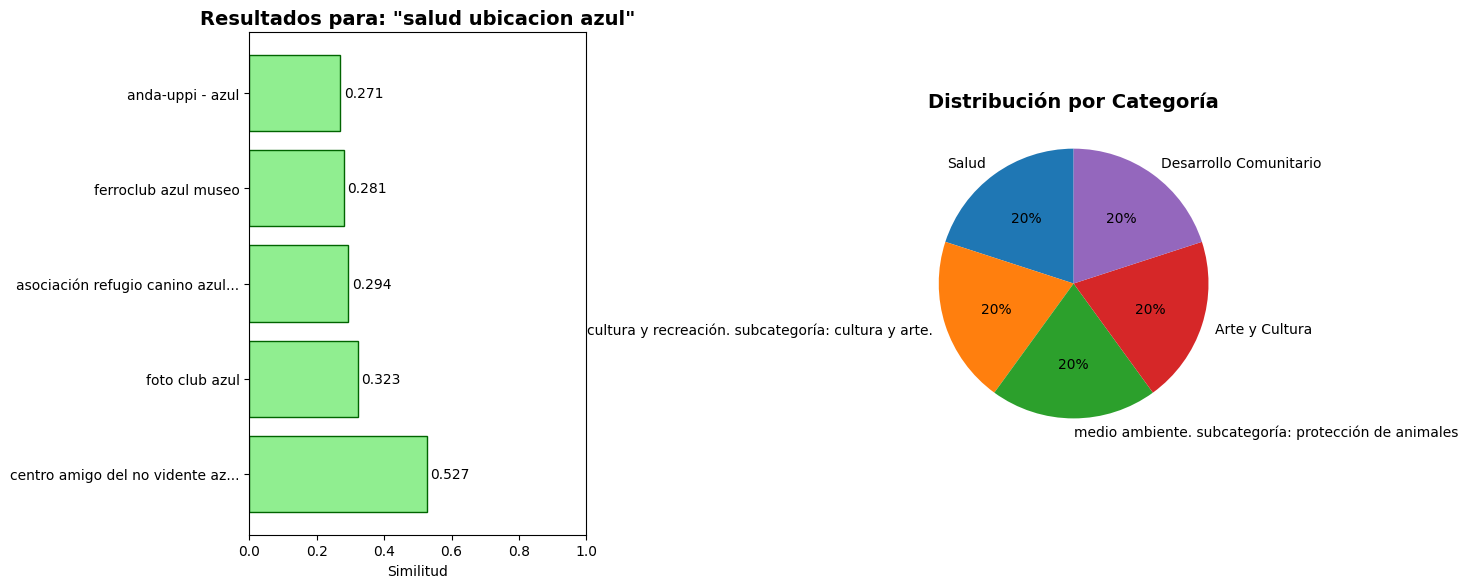

KeyboardInterrupt: Interrupted by user

In [13]:
busqueda_interactiva_avanzada(sistema)